# Temp

In [88]:
import sys
import os
from os.path import join
from datetime import datetime
import importlib
from pprint import pprint
import json
import numpy as np
import pandas as pd
import h5py
import skimage
from tqdm import trange
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import patches
import proplot as pplt

sys.path.append('../..')
from tools import energyVS06 as energy
from tools import image_processing as ip
from tools import plotting as mplt
from tools import utils

sys.path.append('/Users/46h/Research/btf/btf-scripts/')
import scan_patterns as sp

In [2]:
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['grid'] = False

## Load data

In [3]:
datadir = '../../Diagnostics/Data/Measurements/scan-xxpy-image-ypdE-ellipsoid/2022-06-25/'
filenames = os.listdir(datadir)
filenames

['220625153913-scan-xxpy-image-ypdE-ellipsoid.h5']

In [4]:
filename = '220625153913-scan-xxpy-image-ypdE-ellipsoid'
file = h5py.File(join(datadir, filename + '.h5'), 'r')
print(list(file))

['config', 'log', 'scandata']


In [5]:
if 'config' in file:
    config = file['config']
    print(f"'config', {type(config)}")
    for key in config:
        print(f"  '{key}', {type(config[key])}")
        for name in config[key].dtype.names:
            print(f'    {name}: {config[key][name]}')
    # Make dictionary of metadata
    metadata = dict()
    for name in config['metadata'].dtype.names:
        metadata[name] = config['metadata'][name]
else:
    # Old measurement; metadata is in json file.
    metadata = json.load(open(join(datadir, filename + '-metadata.json'), 'r'))
    _metadata = dict()
    for _dict in metadata.values():
        for key, value in _dict.items():
            _metadata[key] = value
    metadata = _metadata
    pprint(metadata)

'config', <class 'h5py._hl.group.Group'>
  'environment', <class 'h5py._hl.dataset.Dataset'>
    timestamp: [1.65618595e+09]
    user: [b'46h']
    host: [b'btf-diag-app1.ics.sns.gov']
    cmd_line: [b'scan3d/scan-xxpy-image-ypdE-ellipsoid.py']
    work_dir: [b'/home/46h/btf-scripts']
  'metadata', <class 'h5py._hl.dataset.Dataset'>
    timestamp: [1.65618596e+09]
    Test_LLRF:FCM_RFQ1:CtlAmpSet: [0.63]
    RFTF_TM:Gate_BeamOn:RR: [5.]
    BTF_MEBT_Mag:PS_QH01:I_Set: [157.94000244]
    BTF_MEBT_Mag:PS_QV02:I_Set: [280.05999756]
    BTF_MEBT_Mag:PS_QH03:I_Set: [6.74547816]
    BTF_MEBT_Mag:PS_QV04:I_Set: [-3.75051265]
    BTF_MEBT_Mag:PS_QH05:I_Set: [0.]
    BTF_MEBT_Mag:PS_QV06:I_Set: [-0.]
    BTF_MEBT_Mag:PS_QV07:I_Set: [-3.0999999]
    BTF_MEBT_Mag:PS_QH08:I_Set: [4.0999999]
    BTF_MEBT_Mag:PS_QV09:I_Set: [-1.85000002]
    BTF_MEBT_Mag:PS_QV10:I_Set: [-1.89999998]
    BTF_MEBT_Mag:PS_QH11:I_Set: [7.19999981]
    BTF_MEBT_Mag:PS_QV12:I_Set: [-6.55000019]
    BTF_MEBT_Mag:PS_QH13:I_

In [6]:
if 'log' in file:
    log = file['log']
    print(f"'log', {type(log)}")
    for item in log.dtype.fields.items():
        print('  ', item)

    print('\nErrors and warnings:')
    for i in range(log.size):
        if not(log[i, 'level'] == 'INFO'.encode('utf')):
            timestr = datetime.fromtimestamp(log[i, 'timestamp']).strftime("%m/%d/%Y, %H:%M:%S")
            print(f"{timestr} {log[i, 'message']}")

'log', <class 'h5py._hl.dataset.Dataset'>
   ('timestamp', (dtype('<f8'), 0))
   ('level', (dtype('S15'), 8))
   ('source', (dtype('S20'), 23))
   ('message', (dtype('S512'), 43))

Errors and warnings:


In [7]:
data = file['scandata']

print(f"'scandata', {type(data)}")
for item in data.dtype.fields.items():
    print('  ', item)

'scandata', <class 'h5py._hl.dataset.Dataset'>
   ('timestamp', (dtype('<f8'), 0))
   ('iteration', (dtype('int64'), 8))
   ('cam34_Saturation', (dtype('<f8'), 16))
   ('cam34_Integral', (dtype('<f8'), 24))
   ('bcm04', (dtype('<f8'), 32))
   ('y_PositionSync', (dtype('<f8'), 40))
   ('xp_PositionSync', (dtype('<f8'), 48))
   ('x_PositionSync', (dtype('<f8'), 56))


In [8]:
acts = ['y_PositionSync', 'xp_PositionSync', 'x_PositionSync']

## Scan overview 

### Data collection frequency

In [9]:
duration = data[-1, 'timestamp'] - data[0, 'timestamp']
iteration_duration = duration / data[-1, 'iteration']
points_per_iteration = len(data) / data[-1, 'iteration']
print(f'{len(data)} points recorded over {duration:.1f} seconds ({(duration / 3600.0):.1f} hours)')
print(f"Number of iterations: {data[-1, 'iteration']}")
print(f'Effective rep rate: {(len(data) / duration):.2f} Hz')
print(f'Time per iteration: {iteration_duration:.2f} seconds')
print(f'Points per iteration: {points_per_iteration:.2f} seconds')

5261 points recorded over 1467.6 seconds (0.4 hours)
Number of iterations: 155
Effective rep rate: 3.58 Hz
Time per iteration: 9.47 seconds
Points per iteration: 33.94 seconds


Look for long pauses during data collection.

reprate = 5.00 Hz
Pauses longer than 30 seconds:
[]
Most pauses are 2.80 seconds


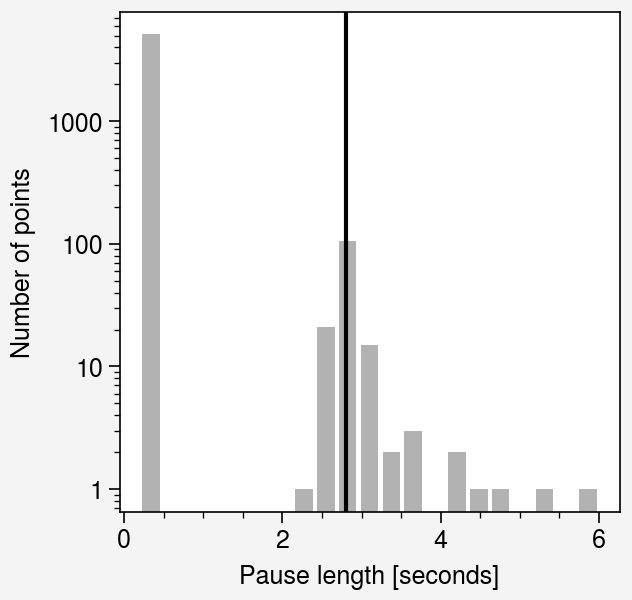

In [10]:
dt = np.diff(data[:, 'timestamp'])
rep_rate = 1.0 / np.median(dt)
print(f'reprate = {rep_rate:.2f} Hz')

print('Pauses longer than 30 seconds:')
long_pause = 30.0
print(dt[dt > long_pause])
dt[dt > long_pause] = 0.2

hist, bins = np.histogram(dt, bins=21)
idx_bins = np.digitize(dt, bins)
idx_pause, = np.where(idx_bins > 1)
median_pause = np.median(dt[idx_pause])
print(f'Most pauses are {median_pause:.2f} seconds')

fig, ax = pplt.subplots()
ax.bar(0.5 * (bins[1:] + bins[:-1]), hist, color='black', alpha=0.3)
ax.axvline(median_pause, color='black')
ax.format(xlabel='Pause length [seconds]', ylabel='Number of points', yscale='log')
plt.savefig('_output/pauses.png')

### Measured beam current

In [11]:
bcm = 'bcm04'
bcm_limit = 20.0  # [mA]
bcm_data = np.copy(data[bcm])

idx = np.arange(len(data))
idx_mask, = np.where(data[bcm] > -bcm_limit)
idx_valid, = np.where(~np.isin(idx, idx_mask))

print(f'Average BCM current (before masking) = {np.mean(bcm_data):.3f} +- {np.std(bcm_data):.3f} [mA]')
for i in idx_mask:
    print(f'Point {i} masked due to {bcm} current < {bcm_limit:.3f} [mA]')
print(f'Average BCM current (after masking) = {np.mean(bcm_data[idx_valid]):.3f} +- {np.std(bcm_data[idx_valid]):.3f} [mA]')

Average BCM current (before masking) = -25.863 +- 0.077 [mA]
Average BCM current (after masking) = -25.863 +- 0.077 [mA]


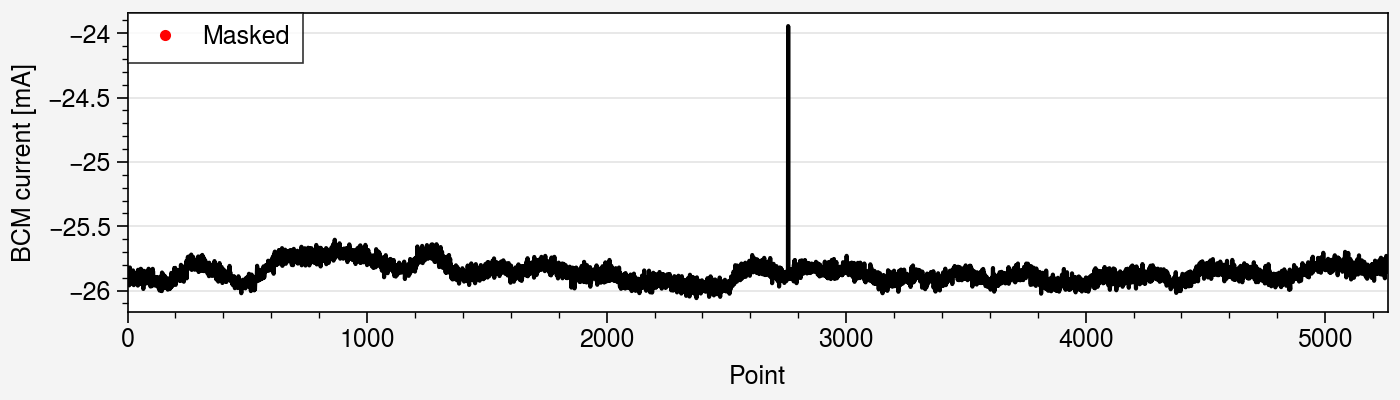

In [12]:
fig, ax = pplt.subplots(figsize=(7.0, 2.0))
ax.plot(bcm_data[idx], color='black')
ax.plot(idx_mask, bcm_data[idx_mask], color='red', lw=0, marker='.', label='Masked')
ax.format(xlabel='Point', ylabel='BCM current [mA]', ygrid=True)
ax.legend(loc='upper left')
plt.savefig('_output/bcm_mask.png')
plt.show()

### Slit positions 

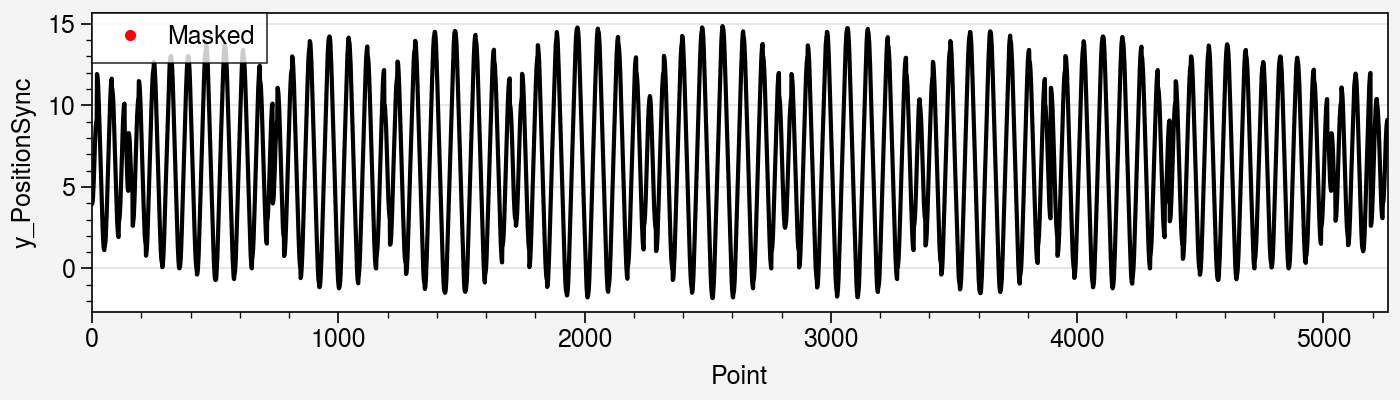

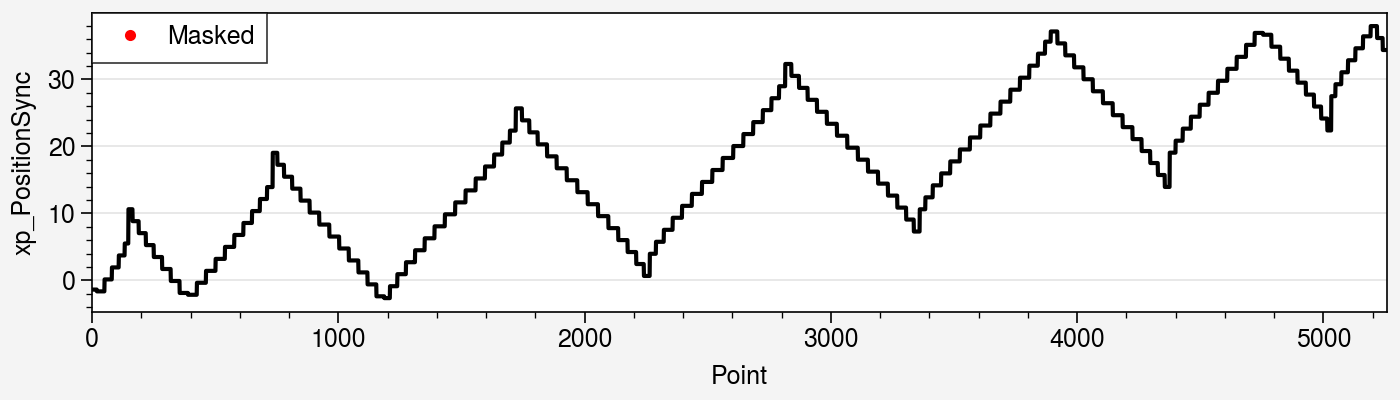

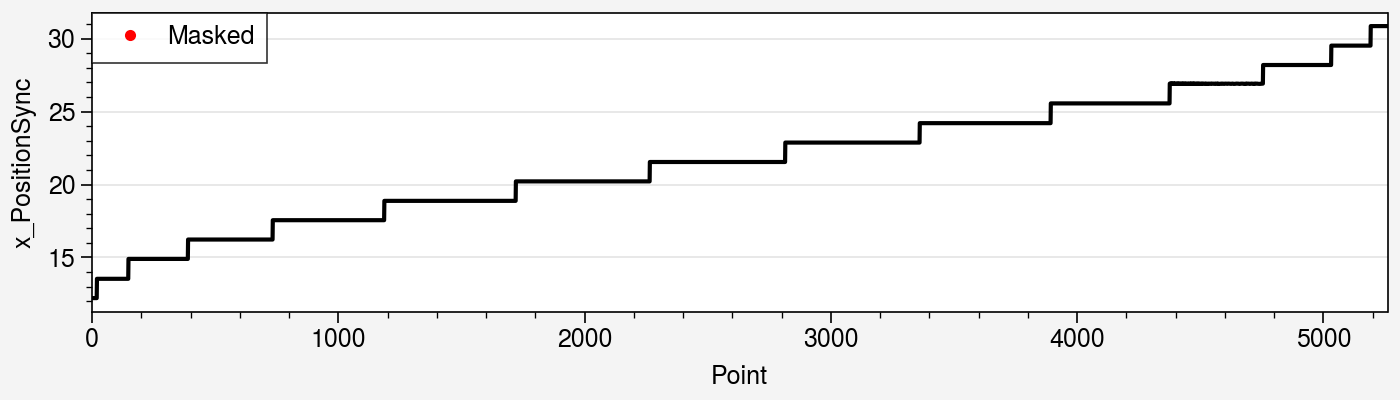

In [13]:
for act in acts:
    fig, ax = pplt.subplots(figsize=(7.0, 2.0))
    ax.plot(idx, data[idx, act], color='black')
    ax.plot(idx_mask, data[idx_mask, act], color='red', lw=0, marker='.', label='Masked')
    ax.format(xlabel='Point', ylabel=act, ygrid=True)
    ax.legend(loc='upper left')
    plt.savefig('_output/acts_mask.png')
    plt.show()

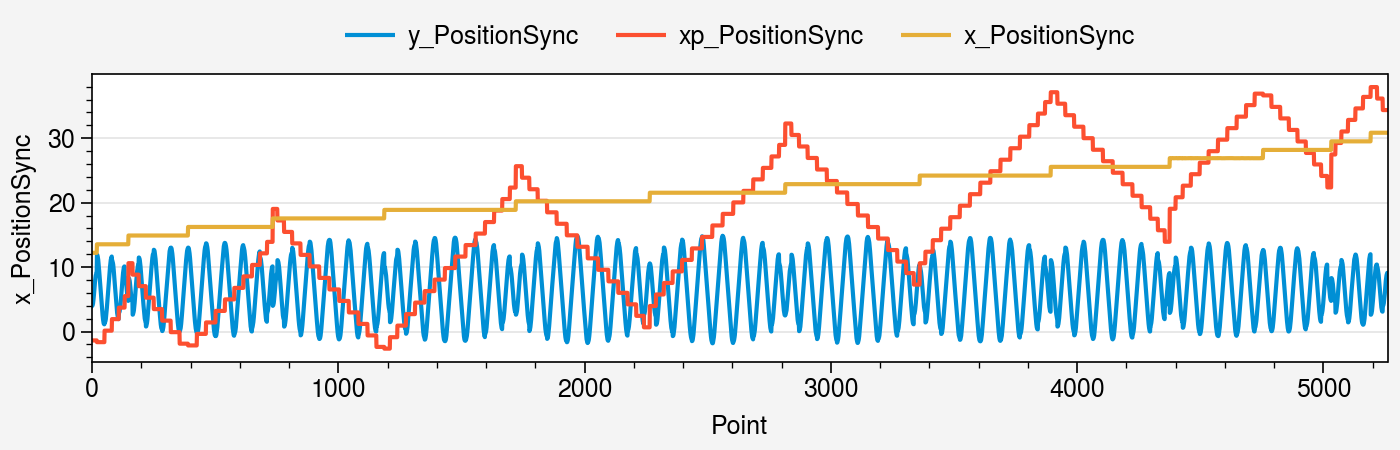

In [14]:
fig, ax = pplt.subplots(figsize=(7.0, 2.25))
ax.format(cycle='538')
for act in acts:
    ax.plot(data[act], color=None, label=act)
    ax.format(xlabel='Point', ylabel=act, ygrid=True)
ax.legend(loc='top', framealpha=0)
plt.savefig('_output/acts.png')
plt.show()

### Iteration numbers

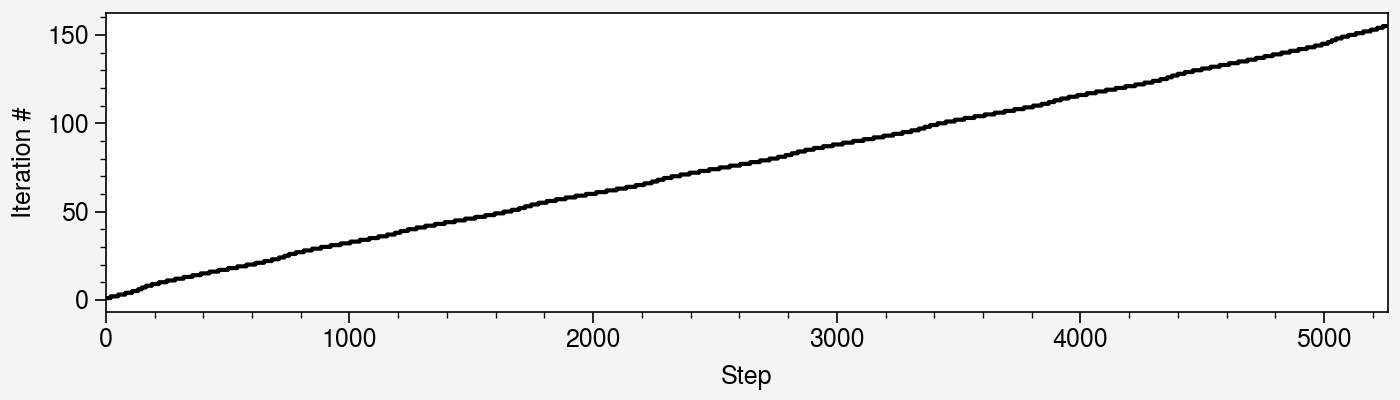

In [15]:
fig, ax = pplt.subplots(figsize=(7, 2))
ax.plot(data['iteration'], color='black')
ax.format(xlabel='Step', ylabel='Iteration #')

## Analysis 

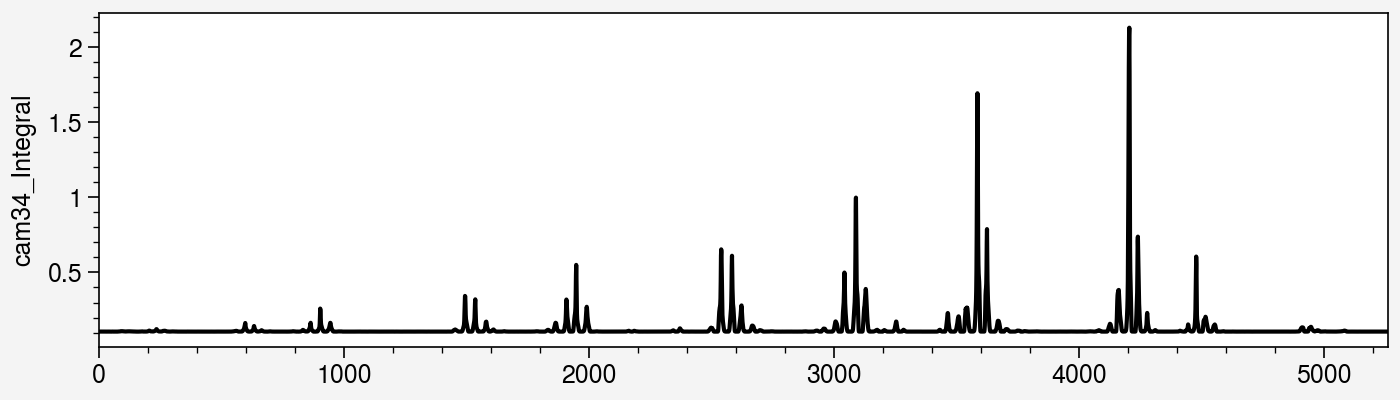

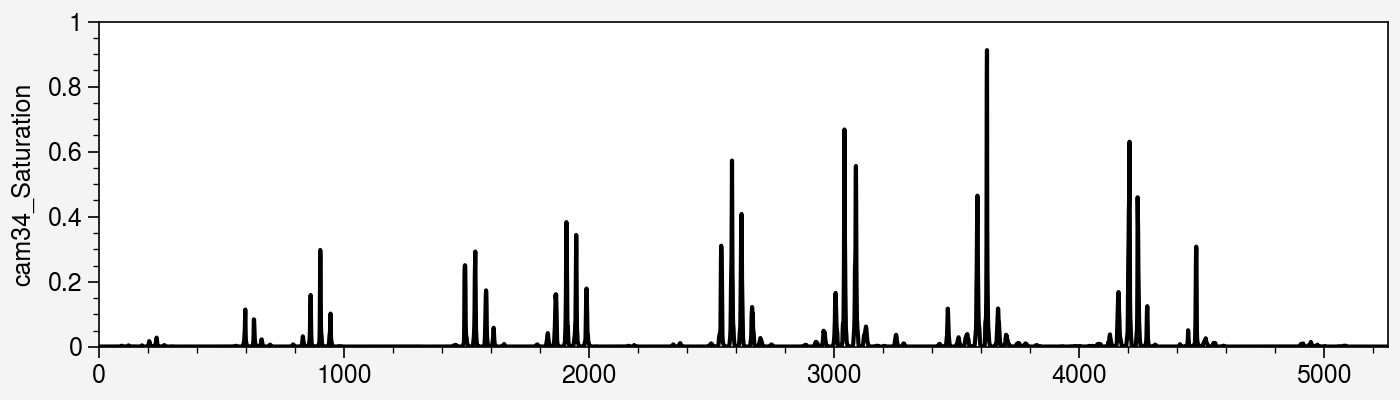

In [16]:
for name in ['cam34_Integral', 'cam34_Saturation']:
    fig, ax = pplt.subplots(figsize=(7, 2))
    ax.plot(data[name], color='black')
    ax.format(ylabel=name)
    if 'saturation' in name.lower():
        ax.format(ylim=(0.0, 1.0))
    plt.show()

In [56]:
ndim = 3
boundary = 'ellipsoid'  # {None, 'ellipsoid'}
inflate = 1.15
slit_dict = {
    'y1': {
        'pvname': 'ITSF_Diag:Slit_HZ34a',
        'center': 5.0,
        'distance': 13.0,
        'steps': 32,
        'min': -50.0, 
        'max': +50.0,
    },
    'x2': {
        'pvname': 'ITSF_Diag:Slit_VT34b',
        'center': 17.0,
        'distance': 23.0,
        'steps': 32,
        'min': -2.0,
        'max': +36.0,
    },
    'x1': {
        'pvname': 'ITSF_Diag:Slit_VT34a',
        'center': 21.5,
        'distance': 21.0,
        'steps': 32,
        'min': -50.0, 
        'max': +50.0,
    },
}
keys = list(slit_dict)
for key in keys:
    slit_dict[key]['distance'] *= inflate

M = np.identity(ndim)
M[keys.index('x1'), keys.index('x2')] = 0.0  
M[keys.index('x2'), keys.index('x1')] = 2.5  
Minv = np.linalg.inv(M)

center = np.array([slit_dict[key]['center'] for key in keys])
distance = np.array([slit_dict[key]['distance'] for key in keys])
nsteps = np.array([slit_dict[key]['steps'] for key in keys])

In [57]:
points = np.vstack([data[act] for act in acts]).T
points_n = utils.apply(Minv, points - center)
points_nn = points_n / (0.5 * distance)
signal = data['cam34_Integral'].copy()
signal = signal / np.max(signal)

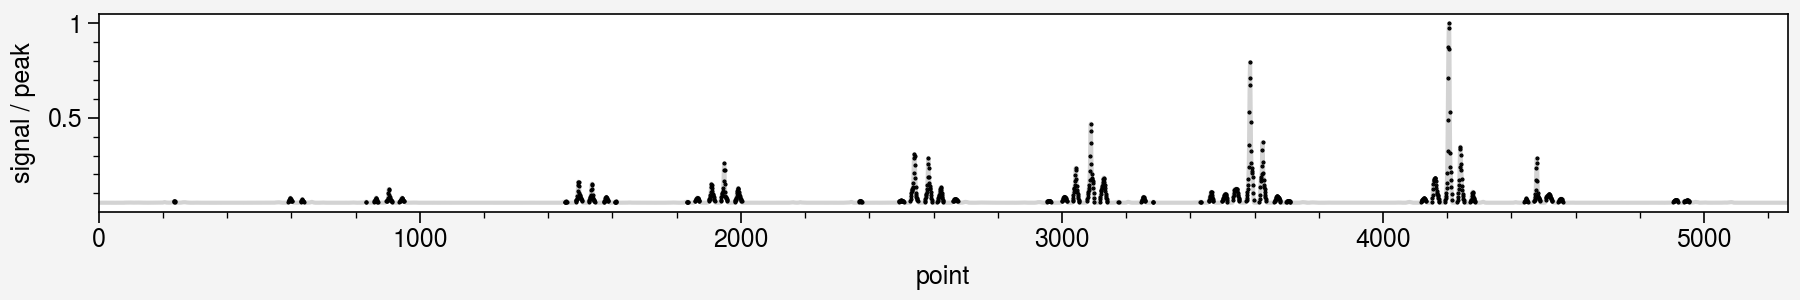

In [58]:
fig, ax = pplt.subplots(figsize=(9.0, 1.5))
thresh = 0.055
idx, = np.where(signal > thresh)
ax.plot(signal, color='lightgrey')
ax.plot(idx, signal[idx], color='black', lw=0, marker='.', ms=1)
ax.format(ylabel='signal / peak', xlabel='point', 
#           yscale='log'
         )
# plt.savefig('_output/signal.png')
plt.show()

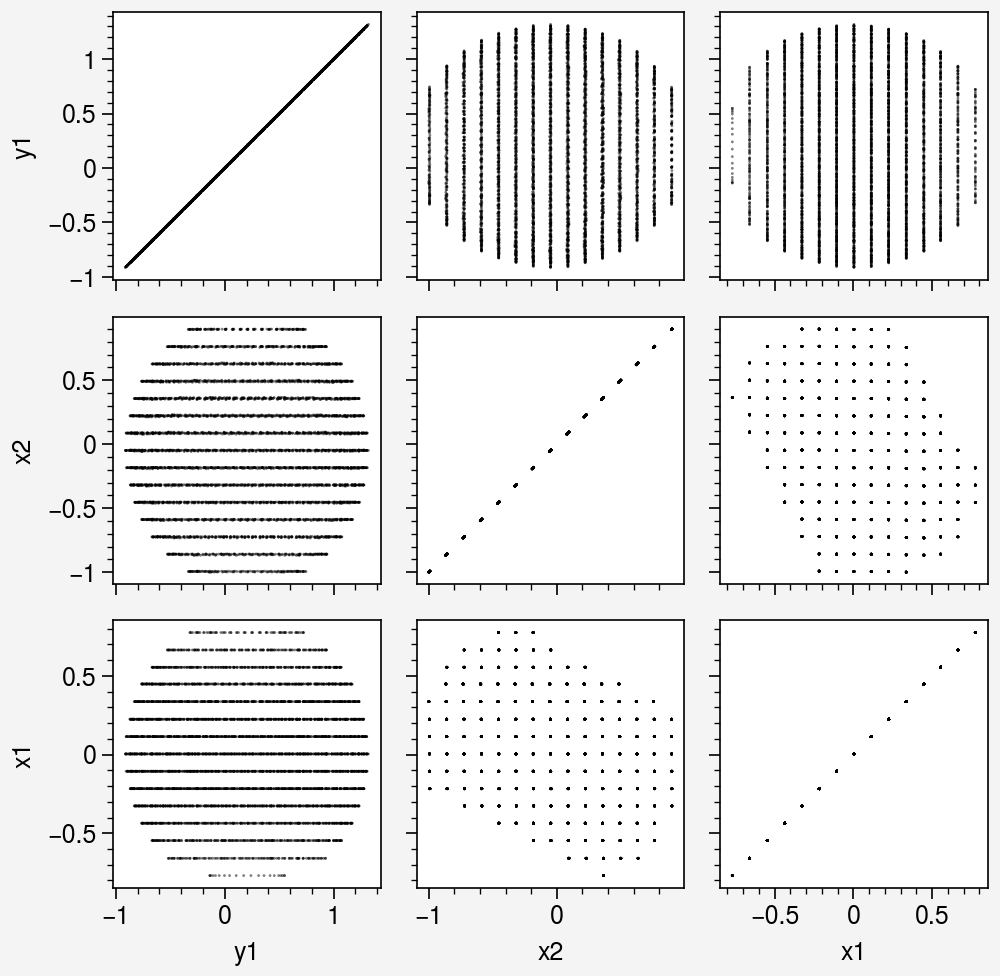

In [80]:
fig, axes = pplt.subplots(ncols=3, nrows=3, figwidth=5, span=False)
dims = ['y1', 'x2', 'x1']
for i in range(3):
    for j in range(3):
        ax = axes[i, j]
        ax.scatter(points_nn[:, j], points_nn[:, i], s=1, alpha=0.5, ec='None', c='black')
        ax.format(xlabel=dims[j], ylabel=dims[i])

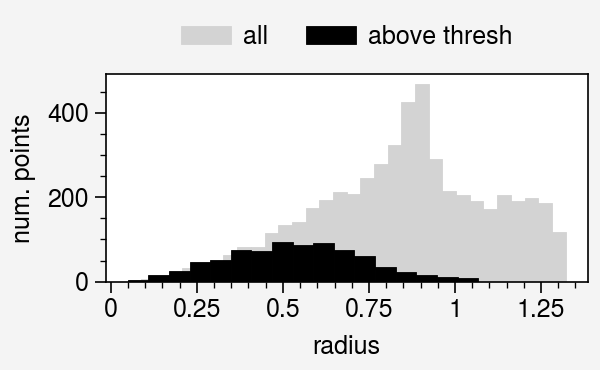

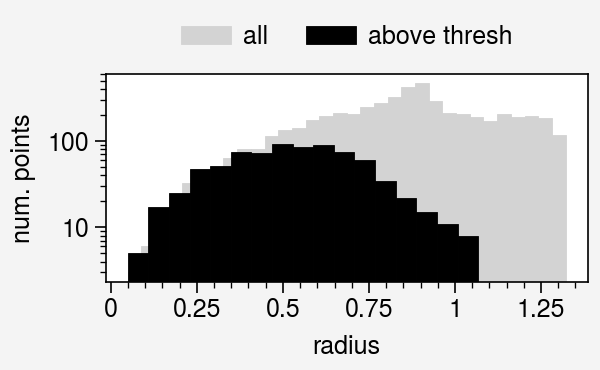

In [51]:
radii = np.sqrt(np.sum(np.square(points_nn), axis=1))

bins = 'auto'
for yscale in [None, 'log']:
    with pplt.rc.context(legendfontsize='medium'):
        fig, ax = pplt.subplots(figsize=(3, 1.85))
        ax.hist(radii, bins=bins, label='all', color='lightgrey')
        ax.hist(radii[idx], bins=bins, label='above thresh', color='black')
        ax.format(ylabel='num. points', xlabel='radius', yscale=yscale)
        ax.legend(ncols=2, loc='top', framealpha=0)
        plt.savefig(f'_output/radii_yscale{yscale}.png')
        plt.show()

In [47]:
print(np.count_nonzero(radii > 1.0) / len(radii))
print(np.count_nonzero(radii[idx] > 1.0) / len(radii[idx]))

0.28207565101691695
0.011421319796954314


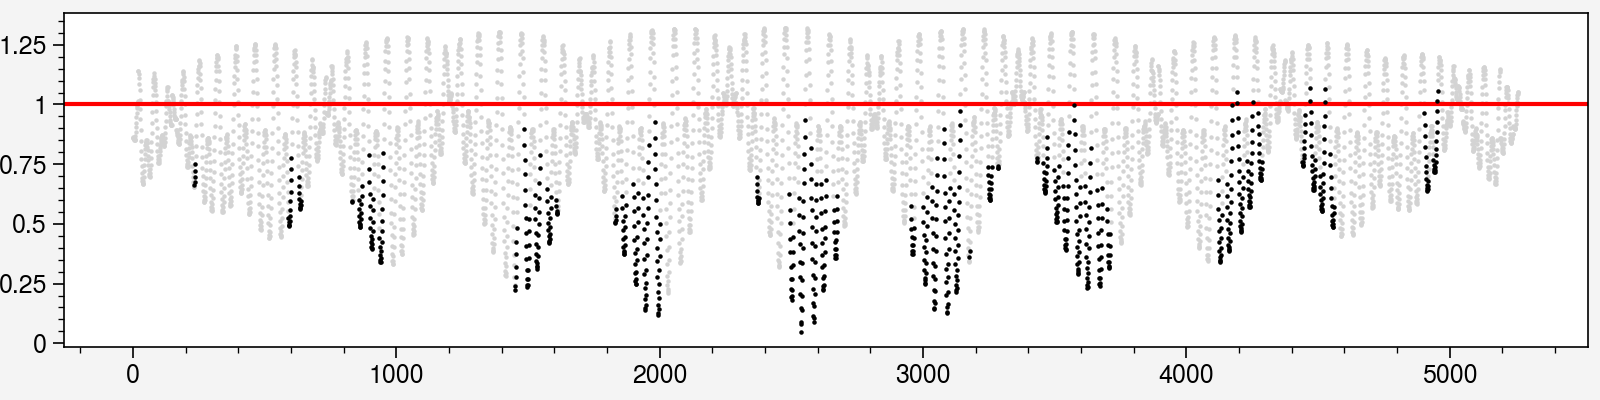

In [42]:
fig, ax = pplt.subplots(figsize=(8.0, 2.0))
ax.scatter(np.arange(len(radii)), radii, c='lightgrey', s=1, zorder=0)
ax.axhline(1.0, color='red', zorder=1)
ax.scatter(idx, radii[idx], c='k', s=1, zorder=2)

In [ ]:
from plotly import graph_objects as go

_points = points_nn
_idx = np.arange(len(points))
_idx = idx

fig = go.Figure(
    data=go.Scatter3d(
        x=_points[_idx, 0], 
        y=_points[_idx, 1], 
        z=_points[_idx, 2],
        mode='markers',
        marker=dict(color='black', size=1, opacity=0.5))
)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
fig.show()

In [69]:
from scipy import interpolate
_points = points_nn
_signal = signal.copy()
_signal[[i for i in range(len(_signal)) if i not in idx]] = 0.0
values = _signal

n = 19
# gvs = [np.linspace(np.min(_points[:, i]), np.max(_points[:, i]), n) for i in range(_points.shape[1])]
gvs = [np.linspace(-1.05, 1.05, n) for i in range(_points.shape[1])]
new_points = tuple([X.ravel() for X in np.meshgrid(*gvs, indexing='ij')])

f = interpolate.griddata(_points, values, new_points, method='linear', fill_value=0.0)
shape = tuple([len(gv) for gv in gvs])
f = f.reshape(shape)

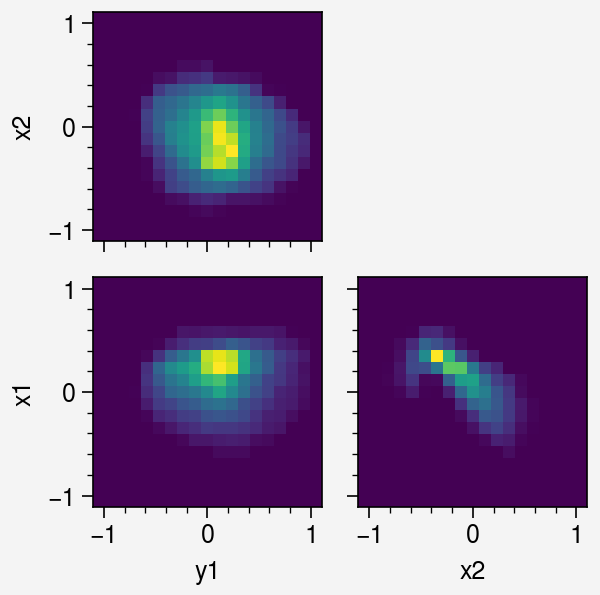

In [70]:
axes = mplt.corner(f, fig_kws=dict(figwidth=3.0), coords=gvs, labels=['y1', 'x2', 'x1'], diag_kind='None')
plt.savefig('_output/rec3d.png')

## Generate new scan boundary 

In [85]:
def gen(center, distance, nsteps, navg=0, start=0): 
    center = np.array([slit_dict[keys[i]]['center'] for i in range(ndim)])
    distance = np.array([slit_dict[keys[i]]['distance'] for i in range(ndim)])
    nsteps = np.array([slit_dict[keys[i]]['steps'] for i in range(ndim)])
    counter = 0
    
    ##### STEPPER SCAN COMMANDS
    if navg > 0:          
        if boundary is None:
            grid = sp.grid(center, distance, nsteps)
        elif boundary == 'ellipsoid':
            grid = sp.ellipsoid(center, distance, nsteps, fit=True)
        else:
            raise ValueError('Invalid boundary parameter.')
        for point in grid:
            realpoint = np.matmul(M, point - center) + center
            # don't let slit destination exceed min/max specified in slit_dict
            # skip points that exceed this limit, but otherwise do not change scan
            skip = False
            for i in range(ndim):
                if (realpoint[i] > slit_dict[keys[i]]['max']) or (realpoint[i] < slit_dict[keys[i]]['min']):
                    skip = True
            if skip:
                continue
            counter += 1
            if counter > start:
                yield realpoint, navg
        
    ##### SWEEPER SCAN COMMANDS
    elif navg == 0:
        sweep_speed = (distance[0] / nsteps[0]) * reprate
        nsteps[0] = 1

        # -- call grid instance and get first point
        if boundary is None:
            grid = sp.grid(center, distance, nsteps)
        elif boundary == 'ellipsoid':
            grid = sp.ellipsoid(center, distance, nsteps, fit=True)
        else:
            raise ValueError('Invalid boundary parameter.')
        lastpoint = next(grid)

        # -- step through grid points
        transition = True
        for point in grid:
            transition ^= True
            # Skip "transition sweeps". In a grid scan, the first variable will not change.
            # If an ellipsoid boundary is used, multiple variables may change. Either way,
            # every other sweep is a transition sweep.
            if (point[0] == lastpoint[0]) or (boundary == 'ellipsoid' and transition):
                lastpoint = point.copy()
                continue
                
            # -- transform to real slit coordinates
            realpoint = np.matmul(M, point - center) + center
            reallastpoint = np.matmul(M, lastpoint - center) + center
            
            # -- copy last point for next iteration
            lastpoint = point.copy()
            
            # -- parse moving/stationary slits on this step
            istay = []
            imove = []; 
            for j in range(0,ndim):
                dxj =  np.abs(realpoint[j] - reallastpoint[j])
                if dxj == 0: # if distance == 0, this point is a stepping point
                    istay.append(j)
                else:
                    imove.append(j)
                 
            ## - this block applies conditions for corner-cutting
            # if slit isn't moving but is in invalid region, skip this step
            skip = False
            for i in istay:
                if (realpoint[i] > slit_dict[keys[i]]['max']) or (realpoint[i] < slit_dict[keys[i]]['min']):
                    skip = True
            if skip:
                continue
            # constrain sweepers to valid region. This may cause
            # odd behavior if there is > 1 sweeper.
            for i in imove:
                if (reallastpoint[i] > slit_dict[keys[i]]['max']):
                    reallastpoint[i] = slit_dict[keys[i]]['max']
                if (reallastpoint[i] < slit_dict[keys[i]]['min']):
                    reallastpoint[i] = slit_dict[keys[i]]['min']
                if (realpoint[i] > slit_dict[keys[i]]['max']):
                    realpoint[i] = slit_dict[keys[i]]['max']
                if (realpoint[i] < slit_dict[keys[i]]['min']):
                    realpoint[i] = slit_dict[keys[i]]['min']
            
            ## - send command if it passed all checks above
            # -- build up cmd list
            cmd = []
            # -- 1st slit always gets sweeper command
            cmd.append((reallastpoint[0], realpoint[0], sweep_speed))
            # -- commands for the rest of the actuators
            for j in range(1,ndim):
                # if slope, stepper may have to sweep as well
                stepper_speed = np.abs(realpoint[j] - reallastpoint[j]) * sweep_speed / distance[0]
                cmd.append((reallastpoint[j], realpoint[j], stepper_speed))   
            
            counter += 1
            if counter > start:
                yield cmd

In [97]:
ndim = 3
pts = np.vstack([data[:, act] for act in acts]).T
idx = signal > thresh
sig_pts = pts[idx, :]

# Run points generator
navg = 0
reprate = 5.0
center = np.array([slit_dict[keys[i]]['center'] for i in range(ndim)])
distance = np.array([slit_dict[keys[i]]['distance'] for i in range(ndim)])
nsteps = np.array([slit_dict[keys[i]]['steps'] for i in range(ndim)])
lgen = list(gen(center, distance, nsteps, navg=navg))

# Reshape
if navg > 0:
    new_pts = np.zeros((len(lgen), ndim))
    for i in range(len(lgen)):
        new_pts[i, :] = lgen[i][0]
else:
    lgen = np.array(lgen)
    new_pts = np.zeros((2 * lgen.shape[0], ndim))
    for i in range(ndim):
        new_pts[:, i] = lgen[:, i, :2].ravel()
    
# Un-shear new (generated) points.
center = np.array([slit_dict['y1']['center'], 
                   slit_dict['x2']['center'], 
                   slit_dict['x1']['center']])
Minv = np.linalg.inv(M)
new_pts_n = utils.apply(Minv, new_pts - center) + center

# Un-shear signal points.
sig_pts_n = np.zeros(sig_pts.shape)
for i in range(sig_pts.shape[0]):
    sig_pts_n[i, :] = np.matmul(Minv, sig_pts[i, :] - center) + center
    
# Get actuator coordinates.
coords = np.vstack([data[:, act] for act in acts]).T
coords_n = np.zeros(coords.shape)
for row in range(coords.shape[0]):
    coords_n[row, :] = np.matmul(Minv, coords[row, :] - center) + center

In [ ]:
fig, axes = pplt.subplots(ncols=3, nrows=3, figwidth=5.0)
for i in range(5):
    
for ax, _pts, _new_pts in zip(axes, [sig_pts, sig_pts_n], [new_pts, new_pts_n]):
    ax.scatter(pts[:, 0], pts[:, 1], marker='s', c=signal, norm='log')
    ax.scatter(_pts[:, 0], _pts[:, 1], marker='s', color='pink1', label='signal')
    ax.plot(_new_pts[:, 0], _new_pts[:, 1], marker='.', s=3, lw=1.0, color='grey', label='scan')
axes.format(xlabel=acts[0], ylabel=acts[1], toplabels=['Sheared', 'Un-sheared'])
# for ax, x, y in zip(axes, [xx, xx_n], [yy, yy_n]):
#     ax.plot(x + center[0], y + center[1], color='black', ls='-', lw=1.0)
axes[0].legend(ncols=1, loc='upper left')
for ax in axes:
    xmin, xmax = ax.get_xlim()
    if xmin > xmax:
        xmin, xmax = xmax, xmin
    ax.set_xlim(xmin, xmax)
# plt.savefig(f'xxpp_ellipse_scan_navg{navg}.png')
plt.show()